2023020001	 200
Aucun point d'événement disponible pour le match 1 à la minute 0.


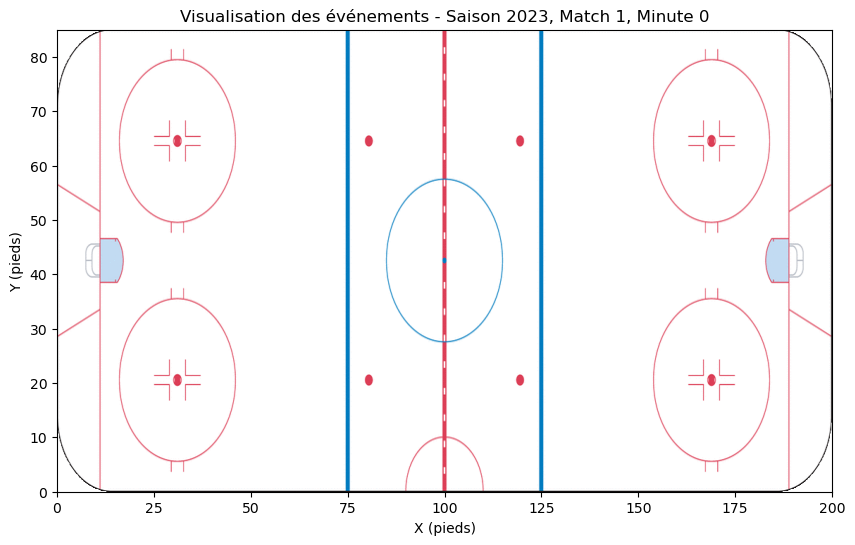

Dropdown(description='Saison:', index=7, options=('2016', '2017', '2018', '2019', '2020', '2021', '2022', '202…

Dropdown(description='Match:', options=('Match 1', 'Match 2', 'Match 3', 'Match 4', 'Match 5', 'Match 6', 'Mat…

Dropdown(description='Type de match:', options=(('Saison régulière', 0), ('Playoffs', 1)), value=0)

IntSlider(value=0, continuous_update=False, description='Minute:', max=60)

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from ipywidgets import widgets
from IPython.display import display, clear_output
from ift6758.data.data_retriever import DataRetriever
import json
import os

# Chemin de l'image du terrain de hockey
rink_image_path = '/ift6758_projet/figures/nhl_rink.png'
data_retriever = DataRetriever()

# Fonction pour récupérer les événements d'un match via l'API
def get_events_from_api(season, game_id, game_type_index=0):
    if game_type_index == 0:
        # Saison régulière
        status, game_data = data_retriever.get_season_game(season, 0, "0001")  # Test avec un match existant
    else:
        # Playoffs
        status, game_data = data_retriever.get_playoffs_game(season, 1, 1, "0001")  # Test avec un match playoffs existant

    if status == 200 and game_data:
        events = game_data.get('liveData', {}).get('plays', {}).get('allPlays', [])
        return events
    else:
        print(f"Erreur lors de la récupération des événements pour le match {game_id} de la saison {season} - Statut {status}.")
        return []

# Fonction pour récupérer les événements à une minute donnée d'un match spécifique
def get_events_for_match(season, match_id, minute, game_type_index=0):
    points = []
    events = get_events_from_api(season, match_id, game_type_index)
    
    for event in events:
        event_time = event.get('about', {}).get('periodTime', '00:00')
        event_minute = int(event_time.split(':')[0])
        if 'coordinates' in event and event_minute == minute:
            x = event['coordinates'].get('x')
            y = event['coordinates'].get('y')
            if x is not None and y is not None:
                points.append((x, y))
    return points

# Fonction pour tracer les événements d'un match à une minute donnée
def plot_events(season, match_id, minute, game_type_index=0):
    clear_output(wait=True)
    points = get_events_for_match(season, match_id, minute, game_type_index)
    
    fig, ax = plt.subplots(figsize=(10, 6))

    if os.path.exists(rink_image_path):
        img = mpimg.imread(rink_image_path)
        ax.imshow(img, extent=[0, 200, 0, 85], aspect='auto')
    else:
        print(f"L'image de la patinoire est introuvable à : {rink_image_path}")
        return

    ax.set_xlim(0, 200)
    ax.set_ylim(0, 85)

    if points:
        x_coords, y_coords = zip(*points)
        ax.scatter(x_coords, y_coords, color='red', zorder=5)
    else:
        print(f"Aucun point d'événement disponible pour le match {match_id + 1} à la minute {minute}.")

    ax.set_xlabel('X (pieds)')
    ax.set_ylabel('Y (pieds)')
    ax.set_title(f'Visualisation des événements - Saison {season}, Match {match_id + 1}, Minute {minute}')
    plt.show()

# Fonction pour mettre à jour le dropdown des matchs (saison régulière ou playoffs)
def update_match_dropdown(season, game_type_index=0):
    data_file_path = f'/ift6758_projet/ift6758/data/{season}/{"playoffs" if game_type_index else "season"}.json'
    if os.path.exists(data_file_path):
        with open(data_file_path, 'r') as f:
            season_data = json.load(f)
        match_list = [f'Match {i+1}' for i in range(len(season_data))]
    else:
        match_list = []
    match_dropdown.options = match_list
    if match_list:
        match_dropdown.value = match_list[0]
    else:
        match_dropdown.value = None

season_dropdown = widgets.Dropdown(
    options=[str(year) for year in data_retriever.GAME_COUNTS.keys()],
    value='2023',
    description='Saison:'
)

match_dropdown = widgets.Dropdown(
    options=[],
    value=None,
    description='Match:'
)

game_type_dropdown = widgets.Dropdown(
    options=[('Saison régulière', 0), ('Playoffs', 1)],
    value=0,
    description='Type de match:'
)

minute_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=60,
    step=1,
    description='Minute:',
    continuous_update=False
)

# Fonction appelée lorsque la saison est modifiée
def on_season_change(change):
    update_match_dropdown(change['new'], game_type_dropdown.value)
    if match_dropdown.options:
        match_index = int(match_dropdown.options[0].split()[-1]) - 1
        plot_events(change['new'], match_index, minute_slider.value, game_type_dropdown.value)

# Fonction appelée lorsque le match est modifié
def on_match_change(change):
    if match_dropdown.value:
        match_index = int(change['new'].split()[-1]) - 1
        plot_events(season_dropdown.value, match_index, minute_slider.value, game_type_dropdown.value)

# Fonction appelée lorsque le type de match est modifié (saison ou playoffs)
def on_game_type_change(change):
    update_match_dropdown(season_dropdown.value, change['new'])
    if match_dropdown.options:
        match_index = int(match_dropdown.options[0].split()[-1]) - 1
        plot_events(season_dropdown.value, match_index, minute_slider.value, change['new'])

# Fonction appelée lorsque la minute change
def on_minute_change(change):
    if match_dropdown.value:
        match_index = int(match_dropdown.value.split()[-1]) - 1
        plot_events(season_dropdown.value, match_index, change['new'], game_type_dropdown.value)

season_dropdown.observe(on_season_change, names='value')
match_dropdown.observe(on_match_change, names='value')
game_type_dropdown.observe(on_game_type_change, names='value')
minute_slider.observe(on_minute_change, names='value')

# Initialisation
update_match_dropdown('2023', 0)
if match_dropdown.options:
    plot_events('2023', 0, 0, 0)

display(season_dropdown, match_dropdown, game_type_dropdown, minute_slider)
